In [51]:
import numpy as np
import matplotlib.pyplot as plt
import quadprog
import Classifier
import kernels
import challengeFunctions as cf


## check that the SVM work correctly

### Create dataset

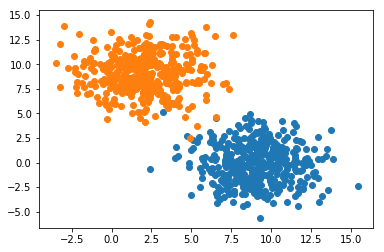

In [54]:
x1 = int(10*np.random.rand())
y1 = int(10*np.random.rand())
x2 = int(10*np.random.rand())
y2 = x1 = int(10*np.random.rand())
X11 = 2*np.random.randn(400) + x1
X12 = 2*np.random.randn(400) + y1

X21 = 2*np.random.randn(400) + x2
X22 = 2*np.random.randn(400) + y2
plt.figure()
plt.scatter(X11,X12)
plt.scatter(X21,X22)
plt.show()

In [55]:
X1 = np.vstack([X11, X12]).T# 100*np.ones(400)]).T
X2 = np.vstack([X21, X22]).T# 100*np.ones(400)]).T
Y =  np.hstack([np.ones(400), -np.ones(400)])
X = np.vstack([X1,X2])

### Define a display result fuction for different Kernels

In [49]:
def display_result(X,Y_true, svm):
    xmax = np.max(X[:,0])
    xmin = np.min(X[:,0])
    ymax = np.max(X[:,1])
    ymin = np.min(X[:,1])
    x = np.linspace(xmin, xmax, 10)
    y = np.linspace(ymin, ymax, 10)
    plt.figure()
    Xid, Y = np.meshgrid(x, y)
    Z = np.zeros((10,10))
    
    for kx in range(10):
        for ky in range(10) :
            
            Z[kx,ky] = svm.predict(np.array([[x[ky],y[kx]]]))
            
    plt.contourf(Xid, Y, Z, 20, cmap='RdGy')
    plt.colorbar()
    plt.contour(Xid, Y, Z, levels = 0,  colors='black')
    
    X1 = X[Y_true == 1]
    X2 = X[Y_true == -1]
    plt.scatter(X1[:,0],X1[:,1], c='red')
    plt.scatter(X2[:,0],X2[:,1], c= 'black')
    plt.show()
            
        
    

     pcost       dcost       gap    pres   dres
 0: -3.2515e+01 -1.9043e+01  4e+03  7e+01  6e-16
 1: -2.0777e+01 -1.0722e+01  2e+02  4e+00  5e-16
 2: -4.5449e+00 -1.5592e+00  2e+01  3e-01  2e-15
 3: -4.4693e-01 -1.1392e+00  7e-01  5e-16  7e-15
 4: -4.7609e-01 -5.4120e-01  7e-02  2e-16  1e-15
 5: -4.9584e-01 -4.9666e-01  8e-04  2e-16  9e-16
 6: -4.9618e-01 -4.9619e-01  8e-06  3e-16  5e-16
 7: -4.9618e-01 -4.9618e-01  8e-08  5e-17  5e-16
Optimal solution found.
Number of non saturated constraints : 

800
score =  0.995


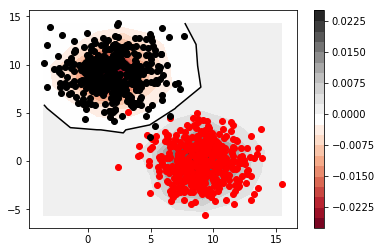

In [56]:
# learn classifier on the data

svm = Classifier.SVM()
svm.lamb = 1
svm.setKernel("gaussian")
svm.train(X,Y)
Ytest = svm.predict(X)

# compute the score
pred = Ytest > 0
pred = 2*pred -1
score = np.sum(pred == Y)/800
print ('score = ', score)

#plot the decisison boundary
display_result(X, Y, svm)

## Test the Baseline

In [42]:
#first we try the baseline
def train_logreg(X,y):
    n = X.shape[0]
    p = X.shape[1]

    omega=np.zeros(p)

    while True:
        eta=1 / (1 + np.exp(np.clip(-X @ omega,-10,10)))

        D_eta=np.diag(eta*(1-eta))

        hessian = np.linalg.inv( X.T @ D_eta @ X )
        add = hessian @ X.T @ (y - eta)
        if np.sum(add >=1e-8) == 0:
            break
        omega = omega + add

    return omega

for i in range(1):
    Xf = np.genfromtxt('../data/Xtr{}_mat50.csv'.format(i))
    yf = np.genfromtxt('../data/Ytr{}.csv'.format(i),skip_header = 1,delimiter = ',')[:,1]
    omega = train_logreg(Xf,yf)

    y_pred = np.ones(Xf.shape[0])
    y_pred[Xf @ omega < 0] = 0
    print("Training accuracy : {}".format(cf.classification_accuracy(y_pred, yf))) 

Training accuracy : 0.644


In [43]:
X = cf.extractdata('../data/Xtr0_mat50.csv', sep = ' ')
Y = cf.extractdata('../data/Ytr0.csv')[1:,1]
Y = Y.astype(int)

In [44]:
Xtrain, Y_train, Xtest, Y_test = cf.splitdata(X,Y)
Xftrain, Yf_train, Xftest, Yf_test = cf.splitdata(Xf,yf)

In [45]:

omega = train_logreg(Xftrain,Yf_train)

y_pred = np.ones(Xftest.shape[0])
y_pred[Xftest @ omega < 0] = 0
print("Training accuracy : {}".format(cf.classification_accuracy(Yf_test, y_pred)))

Training accuracy : 0.592


In [47]:
svm = Classifier.SVM()
svm.lamb = 0.001
svm.setKernel("linear")

Y_train_svm = 2*(Y_train - 1/2)
Y_test_svm = 2*(Y_test - 1/2)
svm.train(Xtrain, Y_train_svm)
y_pred = svm.predict(Xtrain)
y_pred = y_pred > 0
print("Train accuracy for SVM : {}".format(cf.classification_accuracy(Y_train, y_pred)))


     pcost       dcost       gap    pres   dres
 0: -9.6988e+02 -1.1047e+03  8e+03  7e+00  2e-15
 1: -3.8594e+02 -9.6831e+02  6e+02  5e-15  1e-15
 2: -4.5948e+02 -5.0270e+02  4e+01  9e-15  2e-15
 3: -4.9180e+02 -4.9573e+02  4e+00  5e-15  1e-15
 4: -4.9245e+02 -4.9364e+02  1e+00  2e-14  8e-16
 5: -4.9252e+02 -4.9370e+02  1e+00  1e-14  7e-16
 6: -4.9249e+02 -4.9366e+02  1e+00  1e-14  7e-16
 7: -4.9256e+02 -4.9369e+02  1e+00  1e-14  7e-16
 8: -4.9254e+02 -4.9367e+02  1e+00  3e-15  7e-16
 9: -4.9259e+02 -4.9368e+02  1e+00  8e-16  6e-16
10: -4.9261e+02 -4.9368e+02  1e+00  4e-15  6e-16
11: -4.9269e+02 -4.9365e+02  1e+00  2e-15  6e-16
12: -4.9276e+02 -4.9365e+02  9e-01  8e-15  5e-16
13: -4.9290e+02 -4.9359e+02  7e-01  1e-14  5e-16
14: -4.9300e+02 -4.9350e+02  5e-01  2e-14  7e-16
15: -4.9310e+02 -4.9338e+02  3e-01  3e-15  7e-16
16: -4.9313e+02 -4.9334e+02  2e-01  1e-14  6e-16
17: -4.9317e+02 -4.9329e+02  1e-01  6e-15  1e-15
18: -4.9322e+02 -4.9324e+02  2e-02  8e-15  1e-15
19: -4.9323e+02 -4.93